# Pneumonia Detection Project

We have sone Image classification of X_ray images

Here two approaches are used one using CNN and VGG16.

VGG16 is existing model of convolution neural networks.

We used it for transfer learning.

## Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/X_ray_PNUEMONIA_Detection.zip'

Archive:  /content/gdrive/MyDrive/Colab Notebooks/X_ray_PNUEMONIA_Detection.zip
  inflating: X_ray_PNUEMONIA_Detection/Pneumonia_detection_using_Transfer_Learning.ipynb  
  inflating: X_ray_PNUEMONIA_Detection/test_small.zip  
  inflating: X_ray_PNUEMONIA_Detection/train_small.zip  


In [3]:
! unzip '/content/X_ray_PNUEMONIA_Detection/train_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/train_small.zip
   creating: train_small/
   creating: train_small/NORMAL/
  inflating: train_small/NORMAL/IM-0115-0001.jpeg  
  inflating: train_small/NORMAL/IM-0117-0001.jpeg  
  inflating: train_small/NORMAL/IM-0119-0001.jpeg  
  inflating: train_small/NORMAL/IM-0122-0001.jpeg  
  inflating: train_small/NORMAL/IM-0125-0001.jpeg  
  inflating: train_small/NORMAL/IM-0127-0001.jpeg  
  inflating: train_small/NORMAL/IM-0128-0001.jpeg  
  inflating: train_small/NORMAL/IM-0129-0001.jpeg  
  inflating: train_small/NORMAL/IM-0131-0001.jpeg  
  inflating: train_small/NORMAL/IM-0133-0001.jpeg  
  inflating: train_small/NORMAL/IM-0135-0001.jpeg  
  inflating: train_small/NORMAL/IM-0137-0001.jpeg  
  inflating: train_small/NORMAL/IM-0140-0001.jpeg  
  inflating: train_small/NORMAL/IM-0141-0001.jpeg  
  inflating: train_small/NORMAL/IM-0143-0001.jpeg  
  inflating: train_small/NORMAL/IM-0145-0001.jpeg  
  inflating: train_small/NORMAL/IM-0147-0001.jpe

In [4]:
! unzip '/content/X_ray_PNUEMONIA_Detection/test_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/test_small.zip
   creating: test_small/
   creating: test_small/NORMAL/
  inflating: test_small/NORMAL/IM-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0003-0001.jpeg  
  inflating: test_small/NORMAL/IM-0005-0001.jpeg  
  inflating: test_small/NORMAL/IM-0006-0001.jpeg  
  inflating: test_small/NORMAL/IM-0007-0001.jpeg  
  inflating: test_small/NORMAL/IM-0009-0001.jpeg  
  inflating: test_small/NORMAL/IM-0010-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001.jpeg  
  inflating: test_small/NORMAL/IM-0013-0001.jpeg  
  inflating: test_small/NORMAL/IM-0015-0001.jpeg  
  inflating: test_small/NORMAL/IM-0016-0001.jpeg  
  inflating: test_small/NORMAL/IM-0017-0001.jpeg  
  inflating: test_small/NORMAL/IM-0019-0001.jpeg  
  inflating: test_small/NORMAL/IM-0021-0001.jpeg  
  inflating: test_small/NORMAL/IM-0022-0001.jpeg  
  infl

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [6]:
# VGG model requires 224*224 input so we are going to re-size all images
IMAGE_SIZE = [224, 224]

In [7]:
train_path = 'train_small'
valid_path = 'test_small'

# LOad Data by Generator

Generator can create random variations in the given images for generalization of training

In [11]:
# example of progressively loading images from file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
# generator applied random preprocessing to make the model --> robust
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2, # every image will be randomly distorted 0-0.2
                             zoom_range = 0.2, # every image will be randomly zoomed 0-0.2
                             horizontal_flip = True, #
                             vertical_flip=True,
                             rotation_range=30) #every image will be randomly ratated 0-30 degree
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( './train_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
val_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
test_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 101 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Batch shape=(2, 224, 224, 3), min=0.000, max=0.999


# Create Simple CNN model

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential

In [13]:
model = Sequential()

# Conv2D(no of kernal=32, shape of kernel=(5,5), padding, activation
model.add(Conv2D(32, (5,5),padding='valid',activation='relu',
                 input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES

model.add(Conv2D(64, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, (5,5),padding='valid',activation='relu'))

# model.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())    # Flatten() :used to convert miltidimensional array into single dimensional array

# any no of dense layers
model.add(Dense(128,activation='relu'))   # 128 is number of neurons
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 51, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [15]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [16]:
history = model.fit(
  train_it,
  validation_data=val_it,
  epochs=5)

Epoch 1/5
51/51 [==============================] - 11s 116ms/step - loss: 0.6045 - accuracy: 0.7525 - val_loss: 0.9285 - val_accuracy: 0.5000
Epoch 2/5
51/51 [==============================] - 3s 69ms/step - loss: 0.5597 - accuracy: 0.7723 - val_loss: 0.7169 - val_accuracy: 0.5000
Epoch 3/5
51/51 [==============================] - 4s 70ms/step - loss: 0.7588 - accuracy: 0.7723 - val_loss: 1.0590 - val_accuracy: 0.5000
Epoch 4/5
51/51 [==============================] - 6s 119ms/step - loss: 0.5454 - accuracy: 0.7723 - val_loss: 0.8036 - val_accuracy: 0.5000
Epoch 5/5
51/51 [==============================] - 3s 68ms/step - loss: 0.4391 - accuracy: 0.7426 - val_loss: 1.5450 - val_accuracy: 0.5000


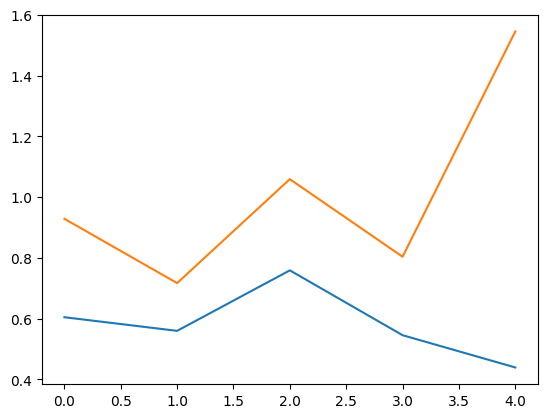

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG
#### [3] add 3 Channles ie RGB
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this
#### Because with help of VGG we are tyring to solve own problem

In [18]:
IMAGE_SIZE = [224, 224]

In [19]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


## Don't train existing weights

In [20]:
for layer in vgg.layers:
  layer.trainable = False

# Add Our Layers at End of VGG16

In [22]:
output_classes = 2

In [23]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [24]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [25]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [27]:
history_vgg= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
)

Epoch 1/5
51/51 [==============================] - 8s 94ms/step - loss: 1.5572 - accuracy: 0.8218 - val_loss: 1.4890 - val_accuracy: 0.7826
Epoch 2/5
51/51 [==============================] - 4s 77ms/step - loss: 0.8493 - accuracy: 0.8614 - val_loss: 1.4748 - val_accuracy: 0.7826
Epoch 3/5
51/51 [==============================] - 6s 109ms/step - loss: 0.8273 - accuracy: 0.8515 - val_loss: 3.3817 - val_accuracy: 0.7174
Epoch 4/5
51/51 [==============================] - 4s 83ms/step - loss: 0.5078 - accuracy: 0.9604 - val_loss: 1.6794 - val_accuracy: 0.7826
Epoch 5/5
51/51 [==============================] - 5s 104ms/step - loss: 0.3488 - accuracy: 0.9604 - val_loss: 0.6909 - val_accuracy: 0.8261


In [28]:
history_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

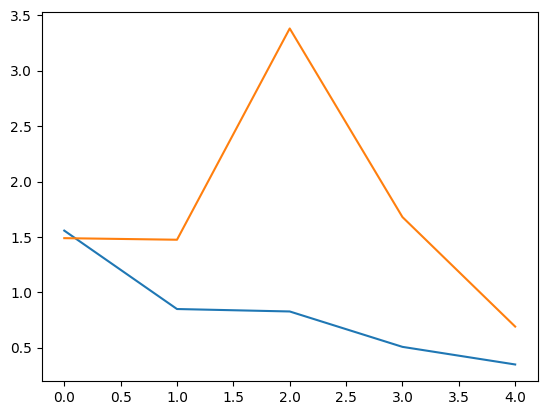

In [29]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

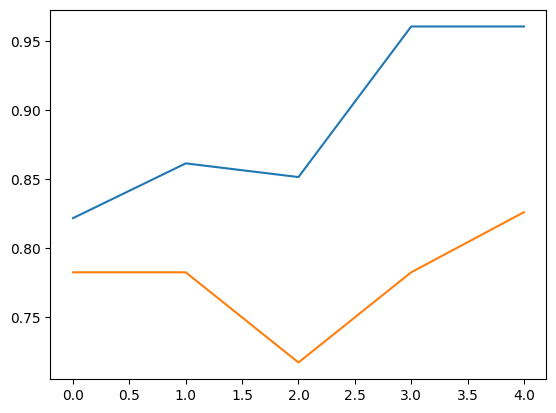

In [30]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])

# Resnet50 Model

In [31]:
from tensorflow.keras.applications import ResNet50

In [32]:
resnet = ResNet50(include_top=True,weights="imagenet",input_shape=(224,224,3),classes=1000)

102967424/102967424 [==============================] - 1s 0us/step


In [33]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [34]:
for layer in resnet.layers[:-2]:
  layer.trainable = False

# Add Our Layers at End of Resnet50

In [35]:
output_classes = 2

In [36]:
# our layers - you can add more if you want
x = Flatten()(resnet.layers[-2].output)
# x = Dense(5000, activation='relu')(x)
# x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [37]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [39]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [40]:
history_resnet= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  )

Epoch 1/5
51/51 [==============================] - 11s 139ms/step - loss: 0.5659 - accuracy: 0.7327 - val_loss: 0.8204 - val_accuracy: 0.5000
Epoch 2/5
51/51 [==============================] - 5s 107ms/step - loss: 0.5332 - accuracy: 0.7723 - val_loss: 0.8956 - val_accuracy: 0.5000
Epoch 3/5
51/51 [==============================] - 6s 113ms/step - loss: 0.5326 - accuracy: 0.7723 - val_loss: 0.9113 - val_accuracy: 0.5000
Epoch 4/5
51/51 [==============================] - 5s 95ms/step - loss: 0.5341 - accuracy: 0.7723 - val_loss: 0.8786 - val_accuracy: 0.5000
Epoch 5/5
51/51 [==============================] - 4s 81ms/step - loss: 0.5263 - accuracy: 0.7723 - val_loss: 0.7625 - val_accuracy: 0.5000


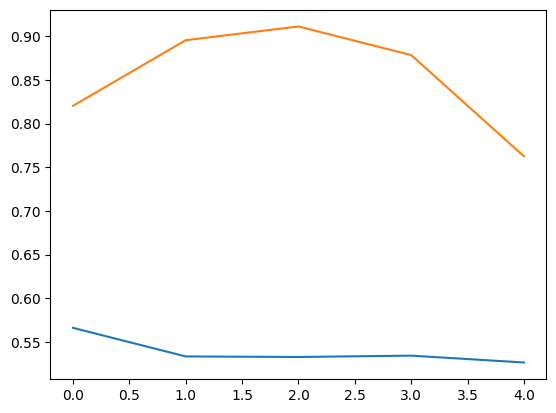

In [41]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

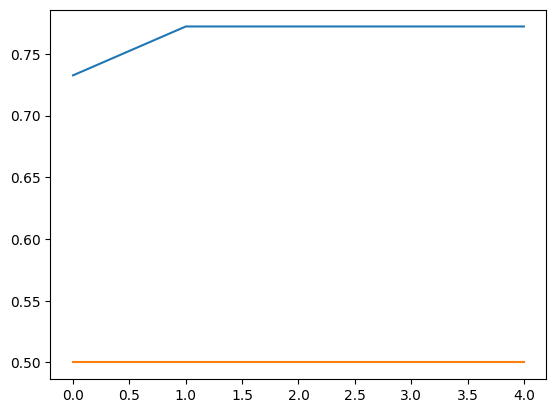

In [42]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])